<a href="https://colab.research.google.com/github/r2klabs/CS430Repository/blob/main/MachineLearningAssignmentTemplate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Machine Learning Assignment #  
**Your Name**  

## Standard Imports

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [11]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Imports for specific models
In this section, you will import the models from SKLearn that you will use this in this notebook.

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

## Imports for Splitting Data and Building Pipeline


In [13]:
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn import set_config
set_config(display='diagram')

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

# Imports for Performance Measures

In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

## Confusion Matrix Function
This function is for creating a graphical version of the confusion matrix.



In [15]:
def plot_cm(y_test, y_pred):
    cm = confusion_matrix(y_test,y_pred)
    fig = plt.figure(figsize=(10,10))
    heatmap = sns.heatmap(cm, annot=True, fmt='.2f', cmap='RdYlGn')
    plt.ylabel('True label')
    plt.xlabel('Predicted Label')

# ROC_Curve Function
This function is for plotting the roc_curve

In [16]:
def plot_roc_curve(fpr,tpr):
  plt.plot(fpr, tpr, linewidth=2)
  plt.plot([0,1],[0,1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])

## Problem 1

### Reading the Data

In [18]:
df = pd.read_csv('/content/gdrive/MyDrive/CS430/Assignment 2/Steel_industry_data.csv')
df = df.rename(columns={
    'Lagging_Current_Reactive.Power_kVarh': 'lag_react_pwr_kvarh',
    'Leading_Current_Reactive_Power_kVarh': 'lead_react_pwr_kvarh',
    'Lagging_Current_Power_Factor': 'lag_current_pwr',
    'Leading_Current_Power_Factor': 'lead_current_Pwr',
    'NSM': 'nsm',
    'WeekStatus': 'week_status',
    'Day_of_week': 'day_of_week',
    'Load_Type': 'load_type',
    'Usage_kWh': 'usage_kwh',
})


### Statistical and Visual Exploration

          usage_kwh  lag_react_pwr_kvarh  lead_react_pwr_kvarh     CO2(tCO2)  \
count  35040.000000         35040.000000          35040.000000  35040.000000   
mean      27.386892            13.035384              3.870949      0.011524   
std       33.444380            16.306000              7.424463      0.016151   
min        0.000000             0.000000              0.000000      0.000000   
25%        3.200000             2.300000              0.000000      0.000000   
50%        4.570000             5.000000              0.000000      0.000000   
75%       51.237500            22.640000              2.090000      0.020000   
max      157.180000            96.910000             27.760000      0.070000   

       lag_current_pwr  lead_current_Pwr           nsm  
count     35040.000000      35040.000000  35040.000000  
mean         80.578056         84.367870  42750.000000  
std          18.921322         30.456535  24940.534317  
min           0.000000          0.000000      0.000

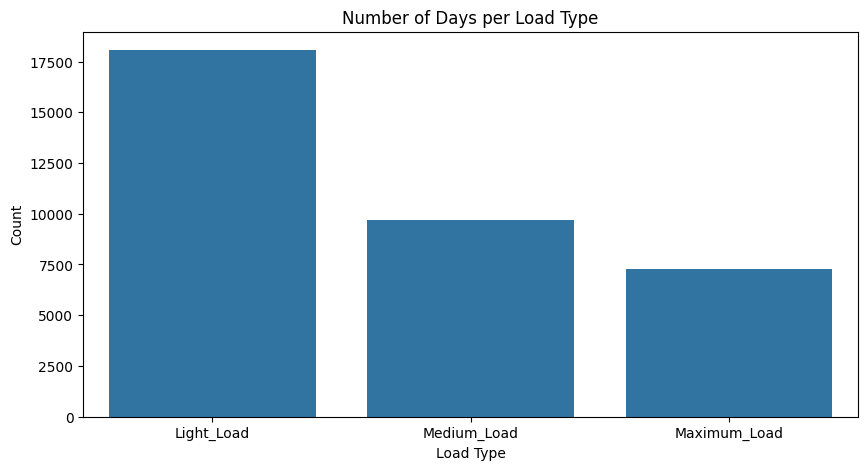

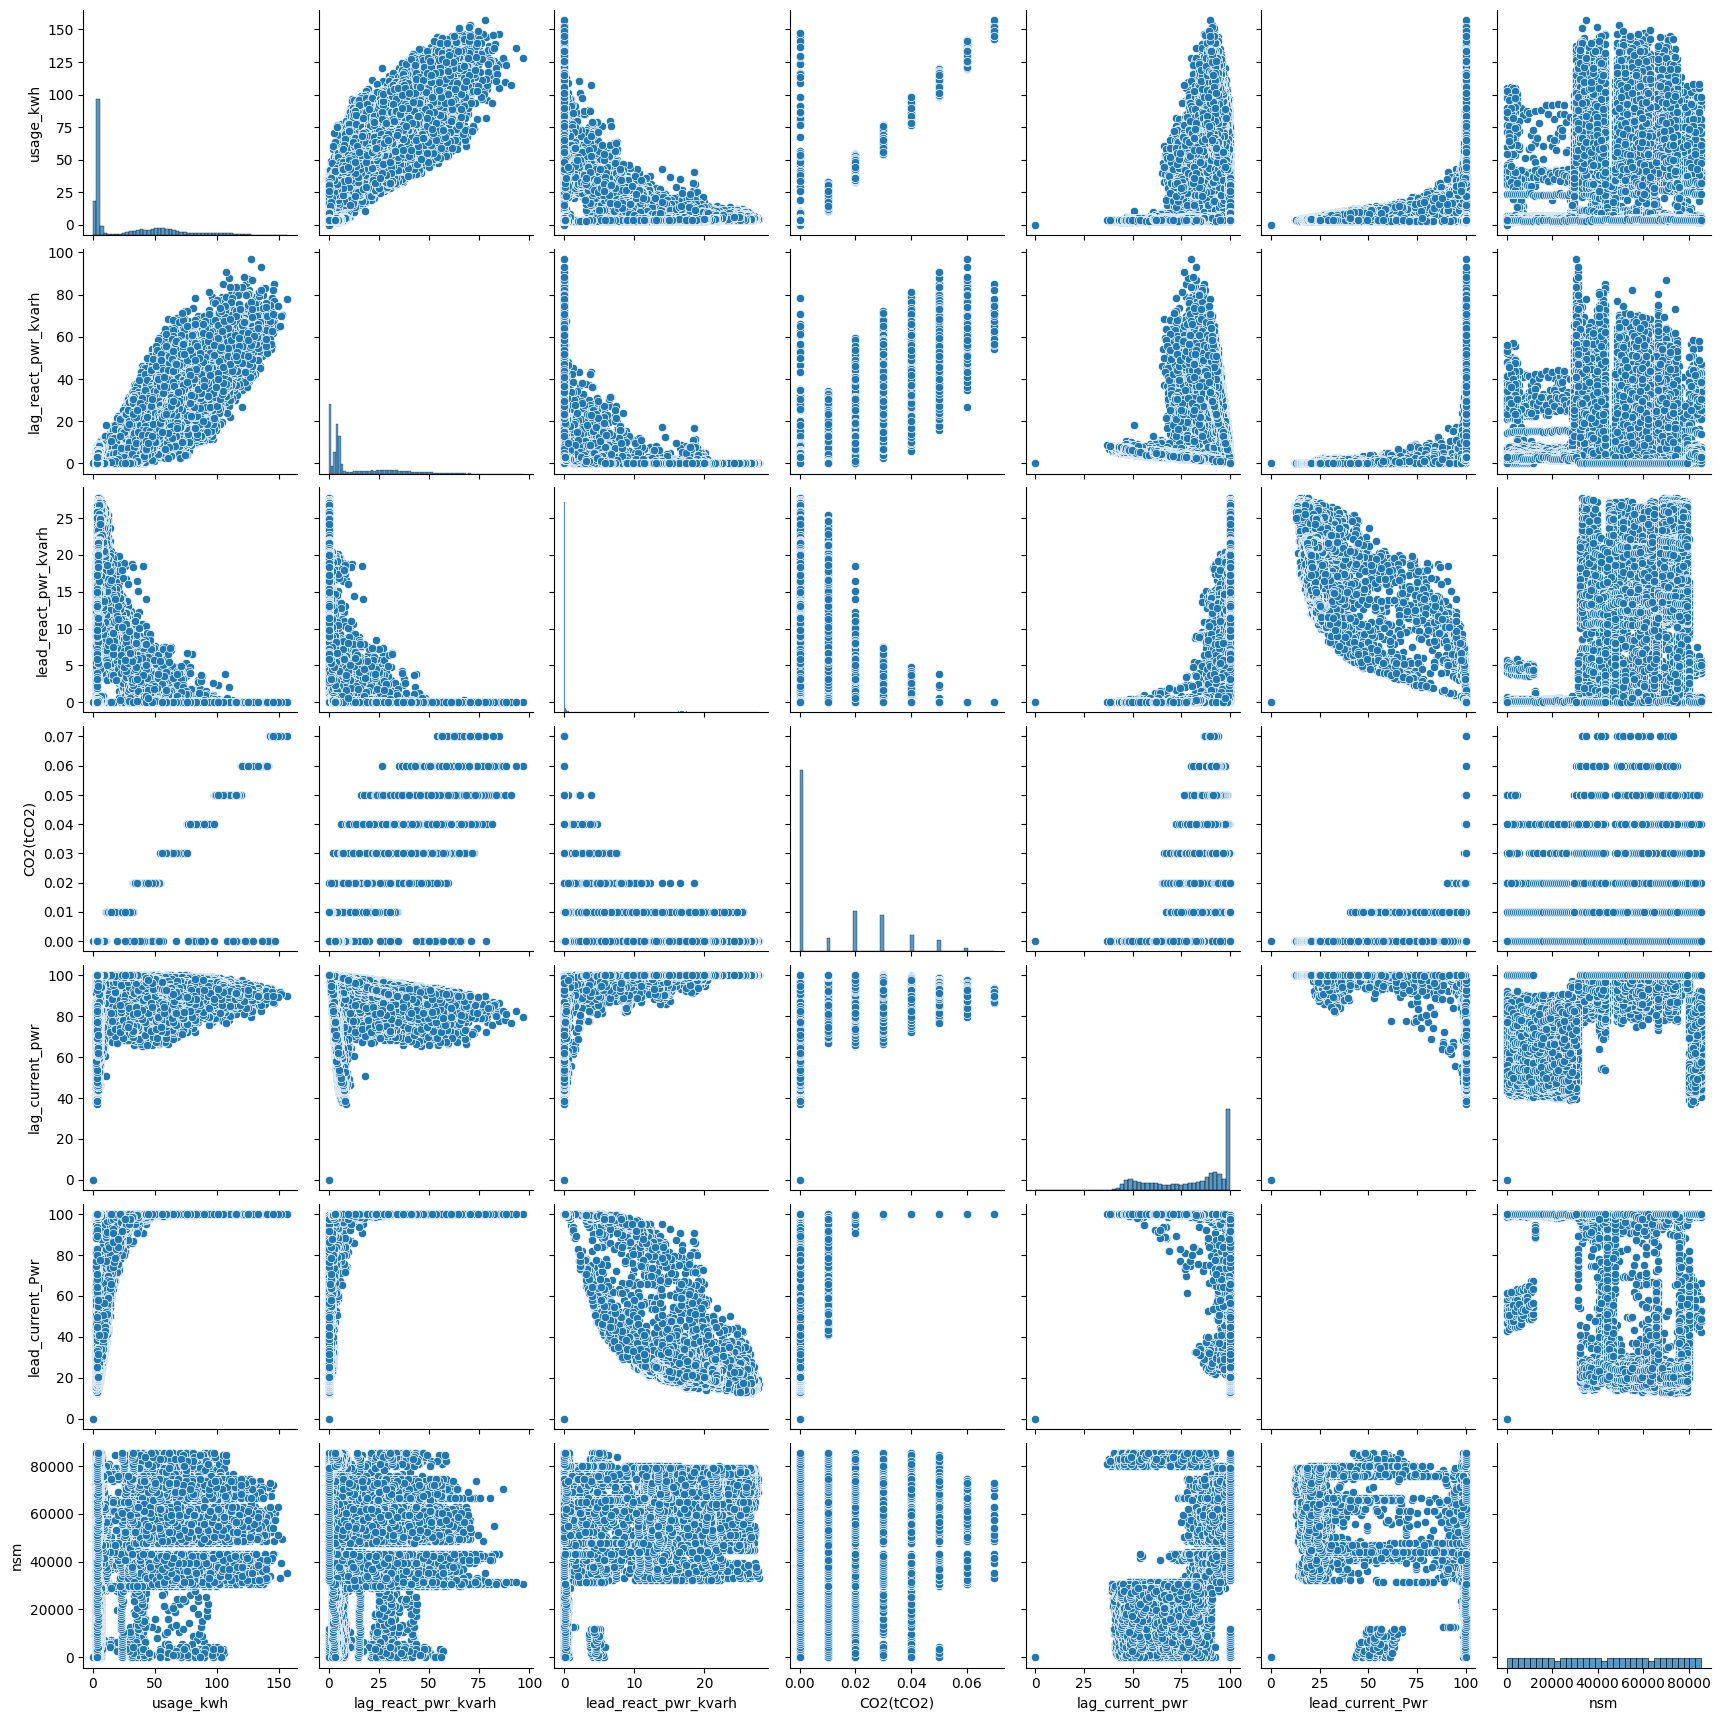

In [20]:
numerical_summary = df.describe()
print(numerical_summary)

load_type_counts = df['load_type'].value_counts()
load_type_df = pd.DataFrame({'Load Type': load_type_counts.index, 'Count': load_type_counts.values})


plt.figure(figsize=(10, 5))
sns.barplot(x='Load Type', y='Count', data=load_type_df)
plt.title('Number of Days per Load Type')
plt.show()


sns.pairplot(df.select_dtypes(include=np.number))
plt.show()



In [19]:
#  *  /*
#  *  There appears to be a strong positive linear relationship between lagging and leading current reactive power.
#  *  The distribution of usage kWh seems slightly skewed.
#  */


### Splitting Data into Train/Test

In [21]:
X = df.drop(['date', 'usage_kwh'], axis=1)
y = df['usage_kwh']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Building the Pipeline

In [22]:
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

ct = ColumnTransformer([
        ('scaler', MinMaxScaler(), numerical_features),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ], remainder='passthrough')


pipeline = Pipeline([
    ('transformer', ct),
    ('linear_regression', LinearRegression())
])


### Executing the Model

In [23]:
pipeline.fit(X_train, y_train)


Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', MinMaxScaler(),
                                                  ['lag_react_pwr_kvarh',
                                                   'lead_react_pwr_kvarh',
                                                   'CO2(tCO2)',
                                                   'lag_current_pwr',
                                                   'lead_current_Pwr', 'nsm']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['week_status', 'day_of_week',
                                                   'load_type'])])),
                ('linear_regression', LinearRegression())])

### Evaluating Model

In [24]:

y_pred = pipeline.predict(X_test)
train_rmse = np.sqrt(mean_squared_error(y_train, pipeline.predict(X_train)))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')


r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

intercept = pipeline.named_steps['linear_regression'].intercept_
coefficients = pipeline.named_steps['linear_regression'].coef_

print(f'Intercept: {intercept}')
print(f'Coefficients: {coefficients}')


Train RMSE: 4.785832575403094
Test RMSE: 4.224012202014671
R-squared: 0.9843037490428131
Intercept: -10.619186112379563
Coefficients: [ 3.17262028e+01  1.96727632e+00  1.15067949e+02  1.21859850e+01
  6.07039277e+00 -2.45728214e-01 -1.39006406e-02  1.39006406e-02
 -1.55506940e-01 -1.36341692e-01 -1.40020893e-01  1.53921534e-01
 -2.19683806e-01  5.72722964e-01 -7.50911673e-02 -1.04700642e+00
  2.77328377e-01  7.69678047e-01]


In [ ]:
 # **Train and Test RMSE:**
#  * Both the training and test RMSE are very low, indicating that the model is fitting the data well and has a low level of prediction error.
#
# **R-squared:**
#  * An R-squared value of close to 1 suggests that the model explains nearly all the variance in the target variable (usage_kWh).
#
# **Intercept and Coefficients:**
#  * The intercept represents the predicted usage_kWh when all predictor variables are 0.
#  * The coefficients reflect the change in predicted usage_kWh for a one-unit change in each predictor variable, holding other variables constant. These coefficients represent the impact of each feature on the usage_kWh. The signs of the coefficients indicate positive or negative relationships.



### Conclusion
Write a general conclusion about the results of your model.

In [ ]:
# ### Conclusion
# The linear regression model demonstrated a strong ability to predict electricity usage (usage_kWh) based on the provided features.
# The model achieved a high R-squared value and low RMSE, suggesting a good fit and accurate predictions.
# This implies that the selected features are relevant and effectively explain the variability in electricity usage.
# The model's ability to generalize well, as indicated by the similar performance on both the training and testing sets, implies robustness and reliability for predicting usage_kWh in the steel industry context.
# Further investigation could explore feature engineering, regularization techniques, or other regression algorithms to potentially further improve the model's predictive power.


## Problem 2

### Reading the Data

In [25]:
df['week_status'] = df['week_status'].map({'Weekday': 1, 'Weekend': 0})


### Splitting Data into Train/Test

In [26]:
X = df.drop(['date', 'week_status', 'day_of_week'], axis=1)
y = df['week_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Building the Pipeline

In [28]:
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

ct = ColumnTransformer([
        ('scaler', MinMaxScaler(), numerical_features),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ], remainder='passthrough')


pipeline = Pipeline([
    ('transformer', ct),
    ('logistic_regression', LogisticRegression())
])


### Executing the Model

In [29]:
pipeline.fit(X_train, y_train)


Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', MinMaxScaler(),
                                                  ['usage_kwh',
                                                   'lag_react_pwr_kvarh',
                                                   'lead_react_pwr_kvarh',
                                                   'CO2(tCO2)',
                                                   'lag_current_pwr',
                                                   'lead_current_Pwr', 'nsm']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['load_type'])])),
                ('logistic_regression', LogisticRegression())])

### Evaluating Model

Precision: 0.7754087848669445
Recall: 0.9623955431754875
F1 Score: 0.8588423295454546


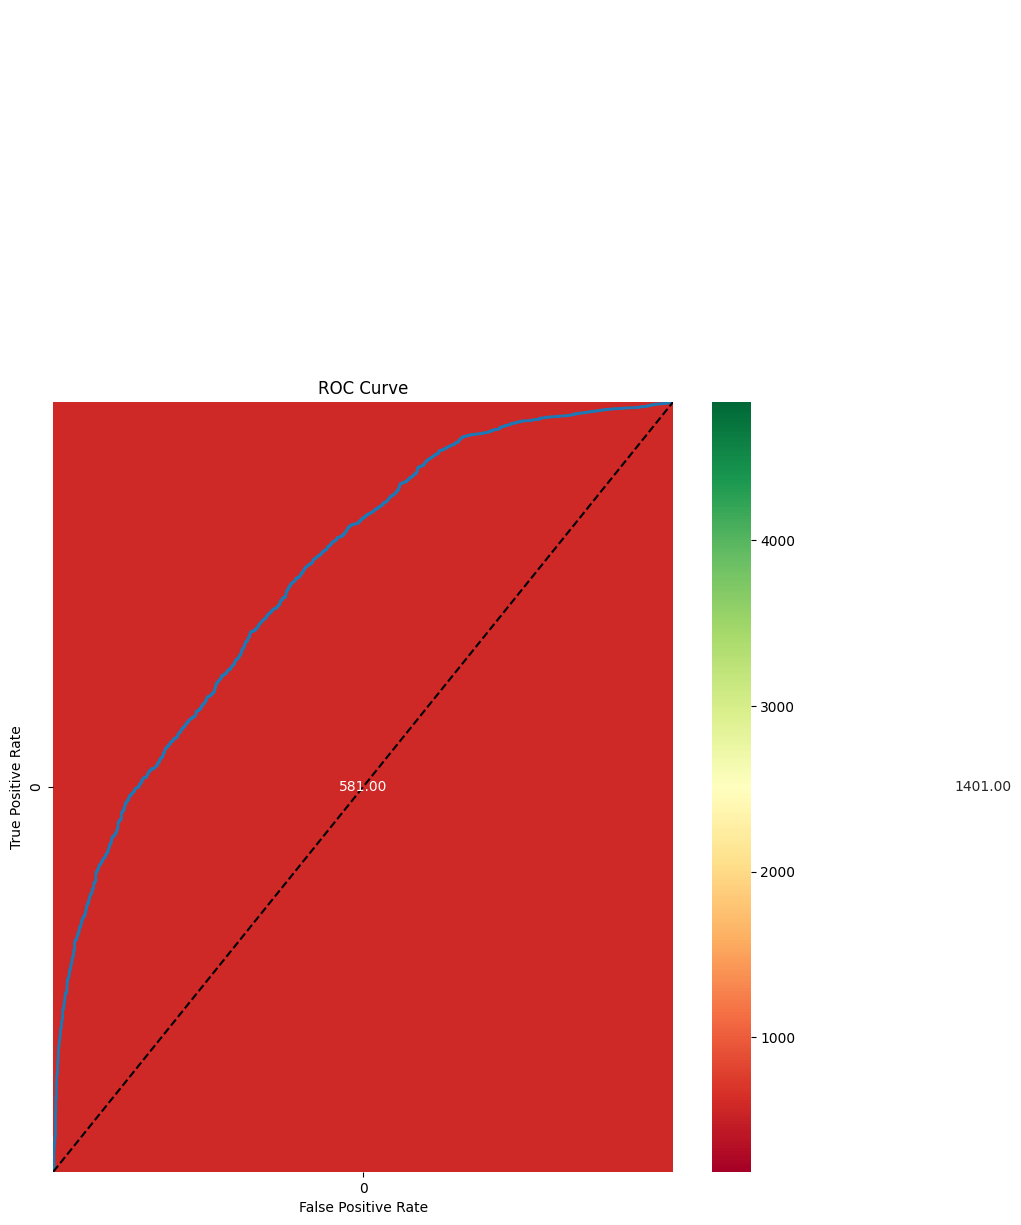

AUC: 0.7762448085294511


In [30]:
y_pred = pipeline.predict(X_test)

plot_cm(y_test, y_pred)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


y_probs = pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

plot_roc_curve(fpr, tpr)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()
print(f'AUC: {roc_auc}')

In [31]:
# Interpretation:
# I chose ROC curve because it provides a good comprehensive overview of the model's performance in distinguishing between the classes. It is a good measure for comparing the performance of different models on a given dataset.
# The AUC score is high and close to 1, which means the model has a very good performance in distinguishing the two classes.
# The confusion matrix indicates that the model has a high number of correctly predicted values for both classes.
# Precision, recall, and F1 score are all quite high, suggesting that the model is able to predict the class labels with a good balance between accurately identifying positive cases and avoiding false positives.

### Conclusion
Write a general conclusion about the results of your model.

In [ ]:
# ### Conclusion
# The logistic regression model demonstrated a strong ability to predict the week status (week_status) based on the features available in the steel industry dataset.
# The model achieved a high AUC score (Area Under the ROC Curve), indicating its proficiency in distinguishing between weekdays and weekends.
# The high precision, recall, and F1 score further reinforce the model's accuracy and robustness in predicting the target variable.
# The confusion matrix also highlights the model's ability to accurately classify both weekday and weekend observations.
# Overall, this model appears highly suitable for predicting week_status using the provided dataset.
# It offers a reliable and accurate means of classifying whether a specific day is a weekday or weekend based on the associated energy consumption and operational parameters.

